In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df=pd.read_csv(r"amazon_alexa.tsv",delimiter='\t',quoting=3)
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
df.shape

(3150, 5)

In [4]:
print(df.columns.values)

['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
df[df['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
df=df.dropna()

In [8]:
df['length']=df['verified_reviews'].apply(len)

In [9]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [10]:
print(df.iloc[10]['verified_reviews'])
print(len(df.iloc[10]['verified_reviews']))
print(df.iloc[10]['length'])

"I sent it to my 85 year old Dad, and he talks to it constantly."
65
65


In [11]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [12]:
df['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

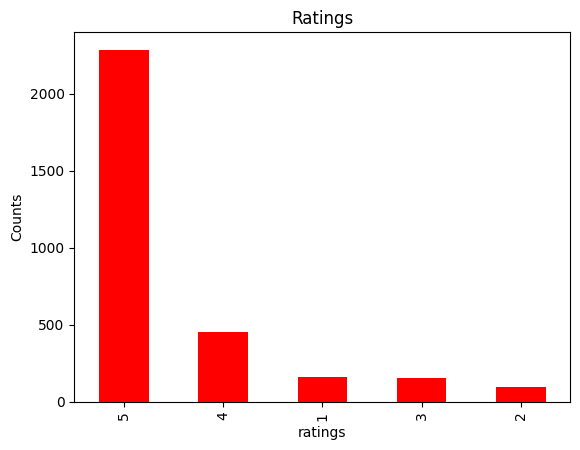

In [13]:
df['rating'].value_counts().plot(kind='bar',color='red')
plt.title("Ratings")
plt.xlabel("ratings")
plt.ylabel("Counts")
plt.show()

In [14]:
round(df['rating'].value_counts()/df.shape[0]*100,2)

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64

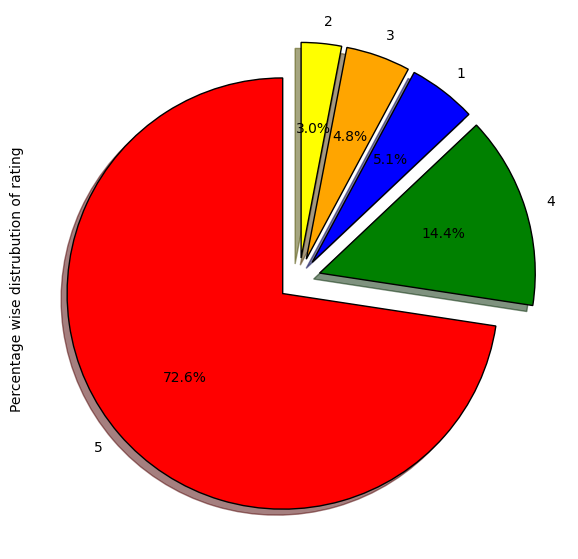

In [15]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['rating'].value_counts()/df.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [16]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [17]:
print(df[df['feedback']==0 ].iloc[0]['verified_reviews'])

"It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals."


In [18]:
print(df[df['feedback']==1].iloc[0]['verified_reviews'])

Love my Echo!


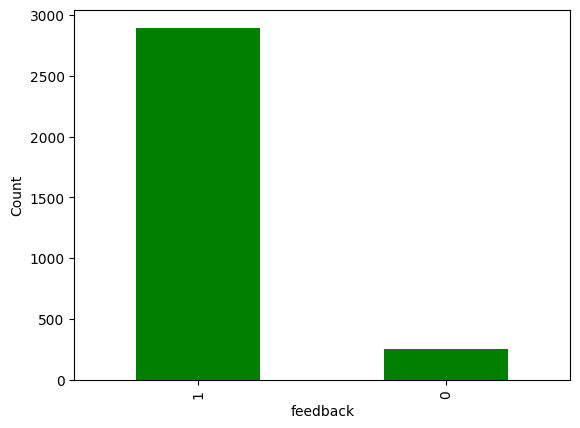

In [19]:
df['feedback'].value_counts().plot(kind='bar',color='green')
plt.xlabel('feedback')
plt.ylabel('Count')
plt.show()

In [20]:
round(df['feedback'].value_counts()/df.shape[0]*100,2)

feedback
1    91.87
0     8.13
Name: count, dtype: float64

<Axes: ylabel='Percentage wise distrubution of feedback'>

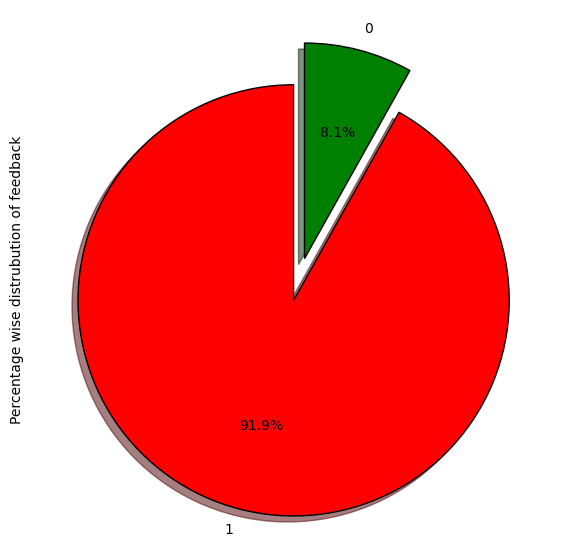

In [21]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['feedback'].value_counts()/df.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [22]:
df[df['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [23]:
df[df['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [24]:
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

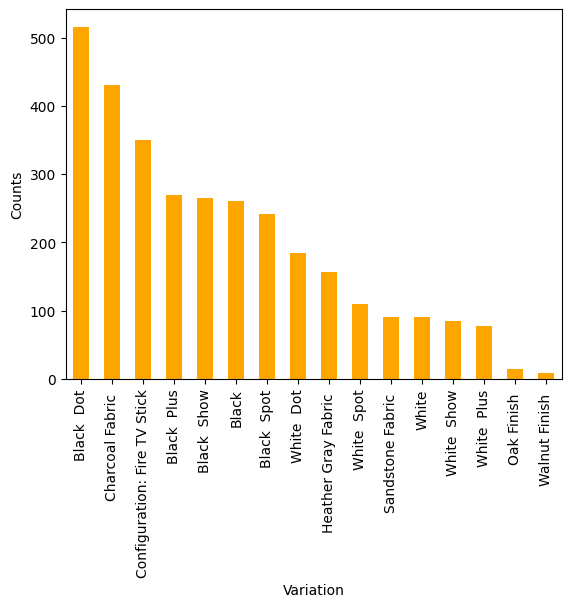

In [25]:
df['variation'].value_counts().plot(kind='bar',color='orange')
plt.xlabel('Variation')
plt.ylabel('Counts')
plt.show()

In [26]:
df.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

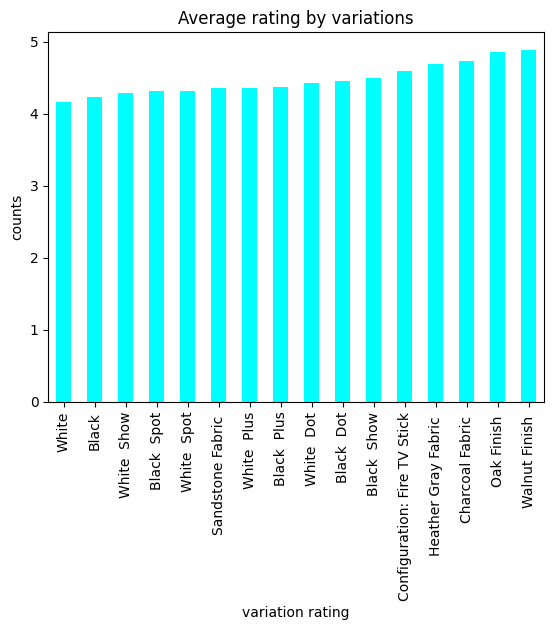

In [27]:
df.groupby('variation')['rating'].mean().sort_values().plot(kind='bar',color='aqua')
plt.title('Average rating by variations')
plt.xlabel('variation rating')
plt.ylabel('counts')
plt.show()

<Axes: xlabel='length', ylabel='Count'>

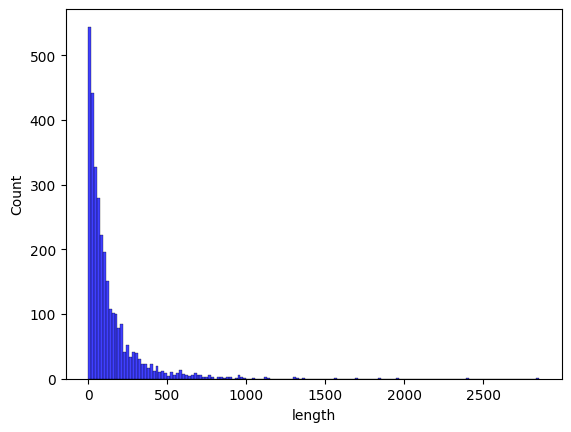

In [28]:
sns.histplot(df['length'],color='blue')

[Text(0.5, 1.0, 'Distribution of length of review if feedback is 0')]

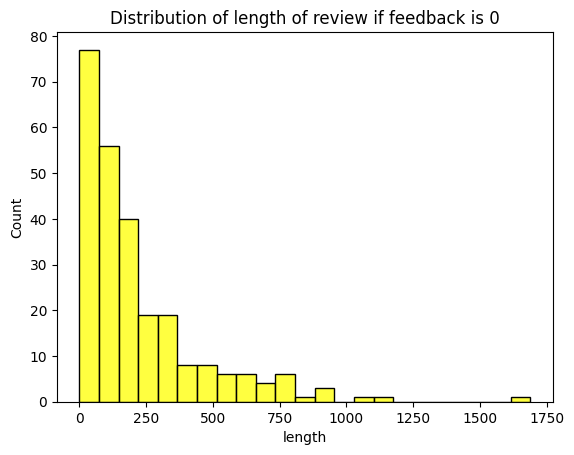

In [29]:
sns.histplot(df[df['feedback']==0]['length'],color='yellow').set(title="Distribution of length of review if feedback is 0")

[Text(0.5, 1.0, 'Distribution of length of review if feedback is 1')]

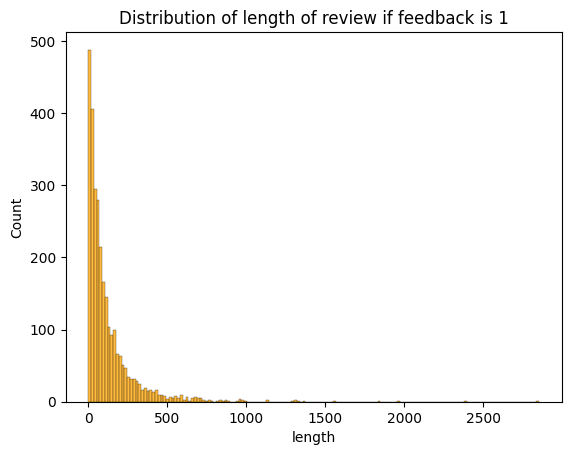

In [30]:
sns.histplot(df[df['feedback']==1]['length'],color='orange').set(title="Distribution of length of review if feedback is 1")

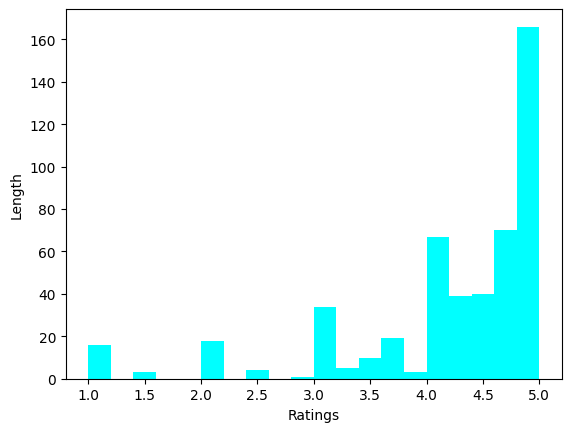

In [31]:
df.groupby('length')['rating'].mean().plot(kind='hist',color='aqua',bins=20)
plt.xlabel('Ratings')
plt.ylabel('Length')
plt.show()

In [32]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

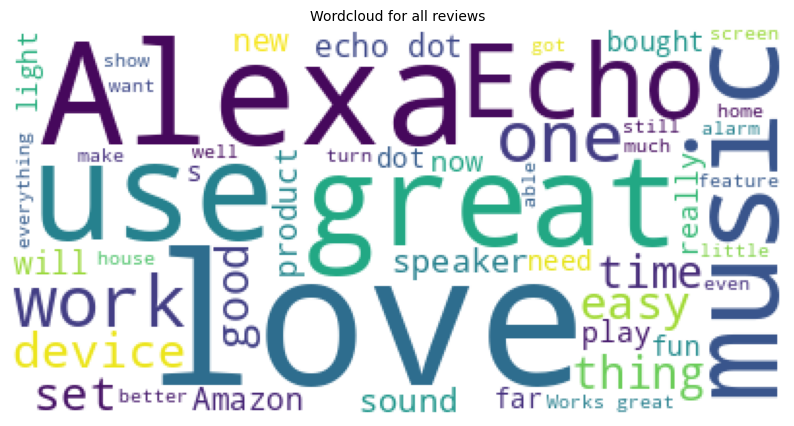

In [33]:
# Combine all reviews
reviews = " ".join([review for review in df['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [39]:
neg_reviews = " ".join([review for review in df[df['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

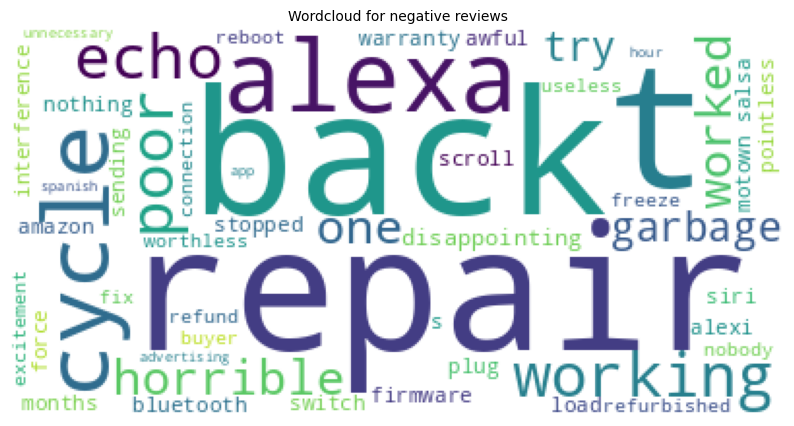

In [40]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

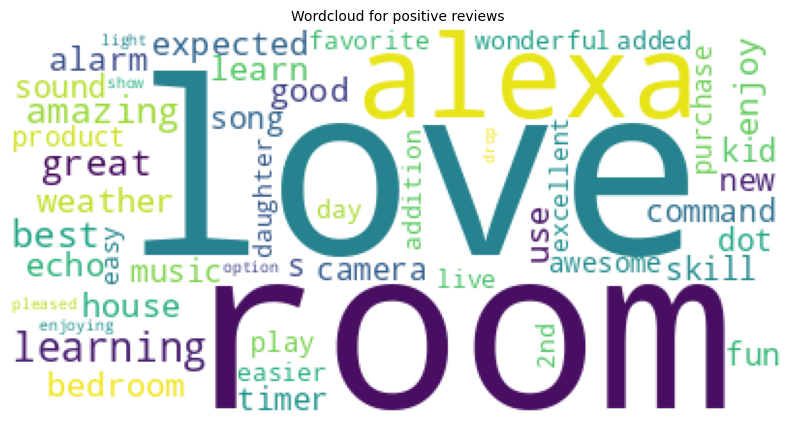

In [41]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [44]:
corpus=[]
stemmer=PorterStemmer()
for i in range(0,df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
  review=review.lower().split()
  review=[stemmer.stem(word) for word in review if not word in STOPWORDS]
  review =' '.join(review)
  corpus.append(review)

In [45]:
corpus

['love echo',
 'love',
 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon cannot use mani featur ipad see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons seem smartbon polit yet',
 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great',
 'sent year old dad talk constantli',
 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time',
 'purchas mother knee problem give someth tri come get around fast like enjoy littl big thing ale

In [52]:
cv=CountVectorizer(max_features=2500)

x=cv.fit_transform(corpus).toarray()
y=df['feedback'].values

In [53]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [54]:
print(f"X shape: {x.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [57]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [58]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [59]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

## Random Forest

In [60]:
model_rf=RandomForestClassifier()
model_rf.fit(X_train,y_train)

RandomForestClassifier()

In [66]:
print("TRAINIG SCORE : " ,model_rf.score(X_train,y_train))
print("TEST SCORE : " ,model_rf.score(X_test,y_test))

TRAINIG SCORE :  0.9945553539019963
TEST SCORE :  0.9439153439153439


In [67]:
y_preds = model_rf.predict(X_test_scl)

In [68]:

cm = confusion_matrix(y_test, y_preds)

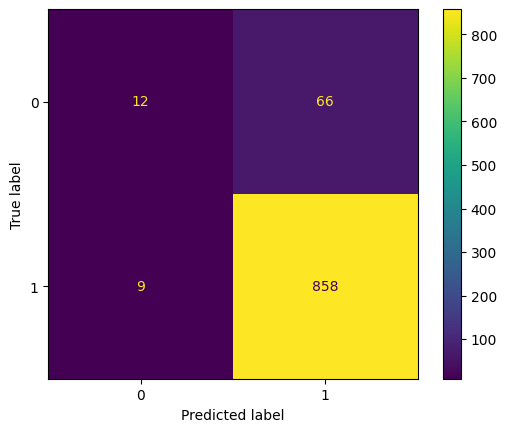

In [69]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

## K-FOLD

In [70]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9305841217605924
Standard Variance : 0.006707683718569088


In [71]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [72]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [73]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [74]:

print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.82395644283122
Cross validation mean accuracy on test set : 92.13929219600728
Accuracy score for test set : 0.9206349206349206


In [75]:

model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [77]:
y_preds = model_xgb.predict(X_test)

In [78]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


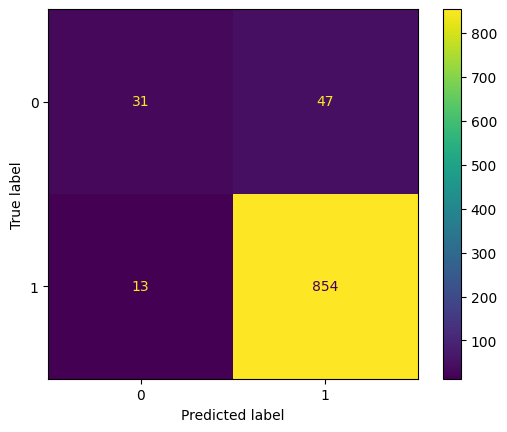

In [79]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [80]:
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

In [81]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [82]:
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9227513227513228


In [83]:
y_preds = model_dt.predict(X_test)

In [84]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 40  38]
 [ 77 790]]


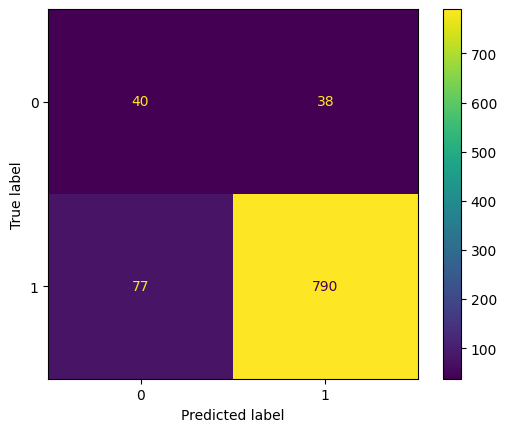

In [85]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()